<a href="https://colab.research.google.com/github/kuan0808/Med_Conversation_NER/blob/master/medical_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ver3.1
## 函式包裝，不用pad，使用pretrain

In [ ]:
import os
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Embedding, \
    GRU, Dense, TimeDistributed, Bidirectional, SpatialDropout1D
from keras.models import Model, Input
from keras.utils import plot_model, Sequence
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import datetime

import jieba
import jieba.posseg as pseg

from sklearn.model_selection \
    import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### teat

In [ ]:
# a = '我是，潘、冠廷......，我是一萬個感恩1234：；:,.、惜福99%，~～12.6%。'
# words = pseg.cut(a)
# print([(word, flag) for word, flag in words])
# print([word for word, flag in words if flag != 'x' and word != '......'])

In [ ]:
train_file_path = '/content/gdrive/My Drive/Colab Notebooks/data/train_1_update.txt'
test_file_path = '/content/gdrive/My Drive/Colab Notebooks/data/SampleData_deid.txt'
os.path.isfile(train_file_path)
os.path.isfile(test_file_path)

True

##  資料預處理

In [ ]:
def preprocess(path, is_train = True):
    content_list = []
    label_list = []
    with open(path, 'r', encoding='utf8') as f:
        raw_data=f.read().encode('utf-8').decode('utf-8-sig')
    articles = raw_data.split('\n\n--------------------\n\n')[:-1]
    for article in articles:
        label_tmp = []
        content = article.split('\n')[0]
        content.replace(' ', '')
        content_list.append(content)
        if is_train:
            for labels in article.split('\n')[2:]:
                label = labels.split('\t')
                label_tmp.append([int(label[1]), int(label[2]), label[4]])
            label_list.append(label_tmp)
    if is_train:
        return content_list, label_list
    return content_list

#### test

In [ ]:
content_list, label_list = preprocess(train_file_path)

print(label_list[-1])

[[33, 36, 'time'], [173, 176, 'time'], [203, 206, 'time'], [222, 226, 'time'], [331, 333, 'time'], [343, 347, 'time'], [378, 380, 'name'], [477, 480, 'time'], [589, 591, 'location'], [593, 595, 'location'], [1075, 1079, 'time'], [1083, 1084, 'time'], [1085, 1086, 'time'], [1087, 1089, 'time'], [1096, 1100, 'time'], [1123, 1125, 'location'], [1128, 1130, 'location'], [1136, 1138, 'location'], [1143, 1145, 'location'], [1173, 1177, 'location'], [1216, 1221, 'name'], [1250, 1255, 'name']]


## Jieba分詞

In [ ]:
def jieba_tokenizer(content_list):
    syntax = ['，', '。', '!', '?', ':', '！', '？', '：', '......', '；', '、', '~', '～', '%', '％']
    word_pos_list = []
    tokenized_content_list = []
    for content in content_list:
        tokenized_content_list_tmp = []
        word_pos_list_tmp = []
        result = jieba.tokenize(content)
        # words = pseg.cut(content)
        # tokenized_content_list_tmp = [word for word, flag in words if (flag != 'x' & word != '......')]
        for word, start, end in result:
            if word not in syntax:
                # try:
                #     num = int(word)
                #     word = '10'
                # except:
                    tokenized_content_list_tmp.append(word)
                    word_pos_list_tmp.append([start, end])

        tokenized_content_list.append(tokenized_content_list_tmp)

        word_pos_list.append(word_pos_list_tmp)
    
    return tokenized_content_list, word_pos_list

### test

In [ ]:
# tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
# print(tokenized_content_list)

##  Pre_train Embedding layer

In [ ]:
##                  ##
##借用別人的pretrain##
##                  ##
dim = 0
word_vecs= {}
# open pretrained word vector file
with open('/content/gdrive/My Drive/Colab Notebooks/Competition_med/cna.cbow.cwe_p.tar_g.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        # there 2 integers in the first line: vocabulary_size, word_vector_dim
        if len(tokens) == 2:
            dim = int(tokens[1])
            continue
    
        word = tokens[0] 
        vec = np.array([ float(t) for t in tokens[1:] ])
        word_vecs[word] = vec

## 轉換詞向量

In [ ]:
def word_to_vector(tokenized_content_list, embedding_dict):
    embedded_list = []

    unk_vector = np.random.rand(*(list(embedding_dict.values())[0].shape))
    for idx in range(len(tokenized_content_list)):
        embedded_list_tmp = []
        for word in tokenized_content_list[idx]:
            if word in embedding_dict.keys():
                embedded_word = embedding_dict[word]
            else:
                embedded_word = unk_vector
                
#             value = embedding_dict.get(word)
#             print(value)
#             if value:
#                 embedded_word = value
#             else:
#                 embedded_word = unk_vector
            embedded_list_tmp.append(embedded_word)
        embedded_list.append(embedded_list_tmp)
    embedded_list = list(map(lambda x: np.array(x, dtype=np.float32), embedded_list))
    return embedded_list

#### test

In [ ]:
# for label in label_list[2]:
#     print(label)

## Dataset萃取

In [ ]:
label_to_index = {'name' : 0, 'location' : 1, 'time' : 2, 'contact' : 3, 'ID' : 4, \
                  'profession' : 5, 'biomarker' : 6, 'family' : 7, 'clinical_event' : 8, \
                  'special_skills' : 9, 'unique_treatment' : 10, 'account' : 11, 'organization' : 12, \
                  'education': 13, 'money' : 14, 'belonging_mark' : 15, 'med_exam' : 16, 'others' : 17, 'O' : 18}

index_to_label = {v: k for k, v in label_to_index.items()}

In [ ]:
def train_dataset(path, word_vecs, validation_ratio, random_state=42, valid=True):
    y_train = []
    content_list, label_list = preprocess(path)
    tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
    x_train = word_to_vector(tokenized_content_list, word_vecs) #未確定
    
    for i in range(len(tokenized_content_list)):
        y_train_tmp = []
        for j in range(len(tokenized_content_list[i])):
            time_stamp = word_pos_list[i][j]
            count = 0
            for label in label_list[i]:
                if time_stamp[0] >= label[0] and time_stamp[1] <= label[1]:
                    y_train_tmp.append(label_to_index[label[2]])
                    count += 1
                    break
            if count == 0:
                y_train_tmp.append(label_to_index['O'])
        y_train.append(y_train_tmp)
    categor_method = lambda x: keras.utils.to_categorical(x)
    y_train = [categor_method(y).astype(np.float32) for y in y_train]    
    if valid:
        x_train, x_val, y_train, y_val = train_test_split(x_train, \
                    y_train,test_size=validation_ratio, random_state=random_state)
        return x_train, x_val, y_train, y_val
    
    return x_train, y_train

#### test

In [ ]:
def test_dataset(path, word_vecs):
    content_list, label_list = preprocess(path)
    tokenized_content_list, word_pos_list = jieba_tokenizer(content_list)
    x_test = word_to_vector(tokenized_content_list, word_vecs)

    return x_test, word_pos_list, content_list

#### test

In [ ]:
x_train, x_val, y_train, y_val = train_dataset(train_file_path, word_vecs, 0.1)
x_test, word_pos_list, content_list = test_dataset(test_file_path, word_vecs)

In [ ]:
print(y_train[10])
print(x_train[1].shape)
for i in range(len(x_train)):
    print(len(x_train[i]) == len(y_train[i]))

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(2720, 512)
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Model建立

## Bidirectional GRU

In [ ]:
input_word = Input(shape = (None, 512))
model = SpatialDropout1D(0.1)(input_word)
model = Bidirectional(GRU(units = 128,return_sequences=True,recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(19, activation ='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 512)]       0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         493056    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 19)          4883      
Total params: 497,939
Trainable params: 497,939
Non-trainable params: 0
_________________________________________________________________


## GRU

In [ ]:
# model = Sequential()

# model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(None, 512)))
# model.add(Bidirectional(GRU(128, return_sequences=True)))
# model.add(TimeDistributed(Dense(19, activation='softmax')))

# model.summary()


In [ ]:
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Data Generator

In [ ]:
def train_generator(x, y):
    while True:
        index = np.random.randint(len(x))
        Xb = np.expand_dims(x[index], axis=0)
        yb = np.expand_dims(y[index], axis=0)
        for i in range(len(x)):
            if (0 <= len(x[i]) - len(x[index]) <= 200) & (i != index):
                x_tmp = np.expand_dims(x[i][:len(x[index])], axis=0)
                y_tmp = np.expand_dims(y[i][:len(y[index])], axis=0)
                Xb = np.append(x_tmp, Xb, 0)
                yb = np.append(y_tmp, yb, 0)
        yield (Xb, yb)

In [ ]:
history = model.fit(train_generator(x_train, y_train), steps_per_epoch=50, epochs=10, verbose=1)

Epoch 1/10
50/50 [==============================] - 304s 6s/step - loss: 0.1505 - accuracy: 0.9686
Epoch 2/10
50/50 [==============================] - 326s 7s/step - loss: 0.0618 - accuracy: 0.9835
Epoch 3/10
50/50 [==============================] - 313s 6s/step - loss: 0.0490 - accuracy: 0.9864
Epoch 4/10
50/50 [==============================] - 309s 6s/step - loss: 0.0443 - accuracy: 0.9873
Epoch 5/10
50/50 [==============================] - 316s 6s/step - loss: 0.0381 - accuracy: 0.9888
Epoch 6/10
50/50 [==============================] - 311s 6s/step - loss: 0.0343 - accuracy: 0.9897
Epoch 7/10
50/50 [==============================] - 294s 6s/step - loss: 0.0297 - accuracy: 0.9909
Epoch 8/10
50/50 [==============================] - 319s 6s/step - loss: 0.0249 - accuracy: 0.9924
Epoch 9/10
50/50 [==============================] - 281s 6s/step - loss: 0.0214 - accuracy: 0.9934
Epoch 10/10
50/50 [==============================] - 298s 6s/step - loss: 0.0183 - accuracy: 0.9943


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

KeyError: ignored

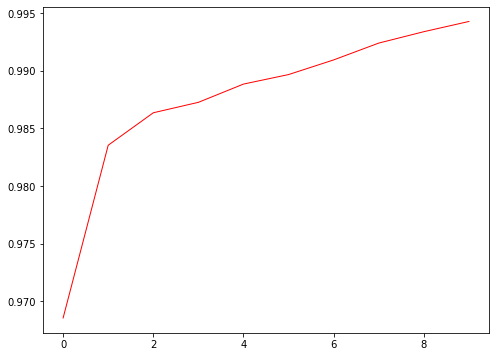

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

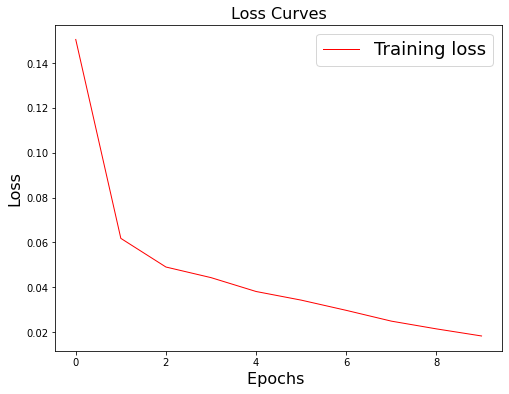

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
def check_merge(label_list):
    merged_label_list = []
    index = 0
    flag = 0
    def bool(idx, flg):
        try:
            f = (label_list[idx+flg][2] == label_list[idx+flg+1][2]) & \
                    (label_list[idx+flg][1] == label_list[idx+flg+1][0])
            return f
        except:
            return False
    while index <= len(label_list)-1:
        if bool(index, flag):
            flag += 1
        else:
            [start, end] = [label_list[index][0], label_list[index+flag][1]]
            merged_label_list.append([start, end, label_list[index][2]])
            index = index + flag + 1
            flag = 0
    return merged_label_list

category_list = []
output = 'article_id\tstart\tend\tentity_word\trntitytype\n'
for article_id in range(len(x_test)):
    y_pred = model.predict(x_test[article_id].reshape(1, *x_test[article_id].shape))

    category_list_tmp = []
    for y in np.squeeze(y_pred):
        category = np.argmax(y)
        category = index_to_label[category]
        category_list_tmp.append(category)
    label_info = []
    for i in range(len(category_list_tmp)):
        label = category_list_tmp[i]
        if label != 'O':
            stamp = word_pos_list[article_id][i]
            label_info.append([stamp[0], stamp[1], label])
    label_info = check_merge(label_info)
    for i in range(len(label_info)):
        output = output + f'{article_id}\t{label_info[i][0]}\t{label_info[i][1]}\t{content_list[article_id][label_info[i][0]:label_info[i][1]]}\t{label_info[i][2]}\n'
    category_list.append(label_info) 

In [ ]:
output_path='output.tsv'
with open(output_path,'w',encoding='utf-8') as f:
    f.write(output)

In [ ]:
df = pd.read_table(output_path)
pd.set_option('display.max_rows', 10000)
df

,article_id,start,end,entity_word,rntitytype
0,0,1376,1378,醫院,location
1,0,1863,1865,十天,time
2,0,2604,2609,3月18號,time
3,0,2613,2616,下禮拜,time
4,0,2622,2625,下禮拜,time
5,0,2630,2635,3月24日,time
6,0,2646,2649,護理師,time
7,0,2650,2654,3月24,time
8,0,2654,2656,醫院,location
9,0,2667,2672,禮拜四其中,time
